# CH06 학습 관련 기술들
가중치 매개변수의 최적값을 탐색하는 최적화 방법  
가중치 매개변수 초깃값  
하이퍼파라미터 설정 방법  
과대적합의 대응책(가중치 감소, 드롭아웃)
배치 정규화

## 6.1 매개변수 갱신

신경망 학습의 목적은 손실함수의 값을 가능한 한 낮추는 매개변수를 찾는 것  
즉, 매개변수의 최적값을 찾는 문제 (**최적화 문제**)  

지금까지 찾는 단서로 기울기(미분)이용  
매개변수의 기울기를 구해 기울어진 방향으로 매개변수값을 갱신하는 일을 반복(확률적경사하강법SGD)

In [1]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr

    def update(self,params,grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

**SGD의 단점**  
SGD는 단순하고 구현도 쉽지만 문제에 따라서는  비효율적일 때 있음  
예를 들어  
$$f(x,y) = \frac{1}{20} x^2 + y^2$$
그래프는 다음과 같음 (사진 GeoGebra로 제작)

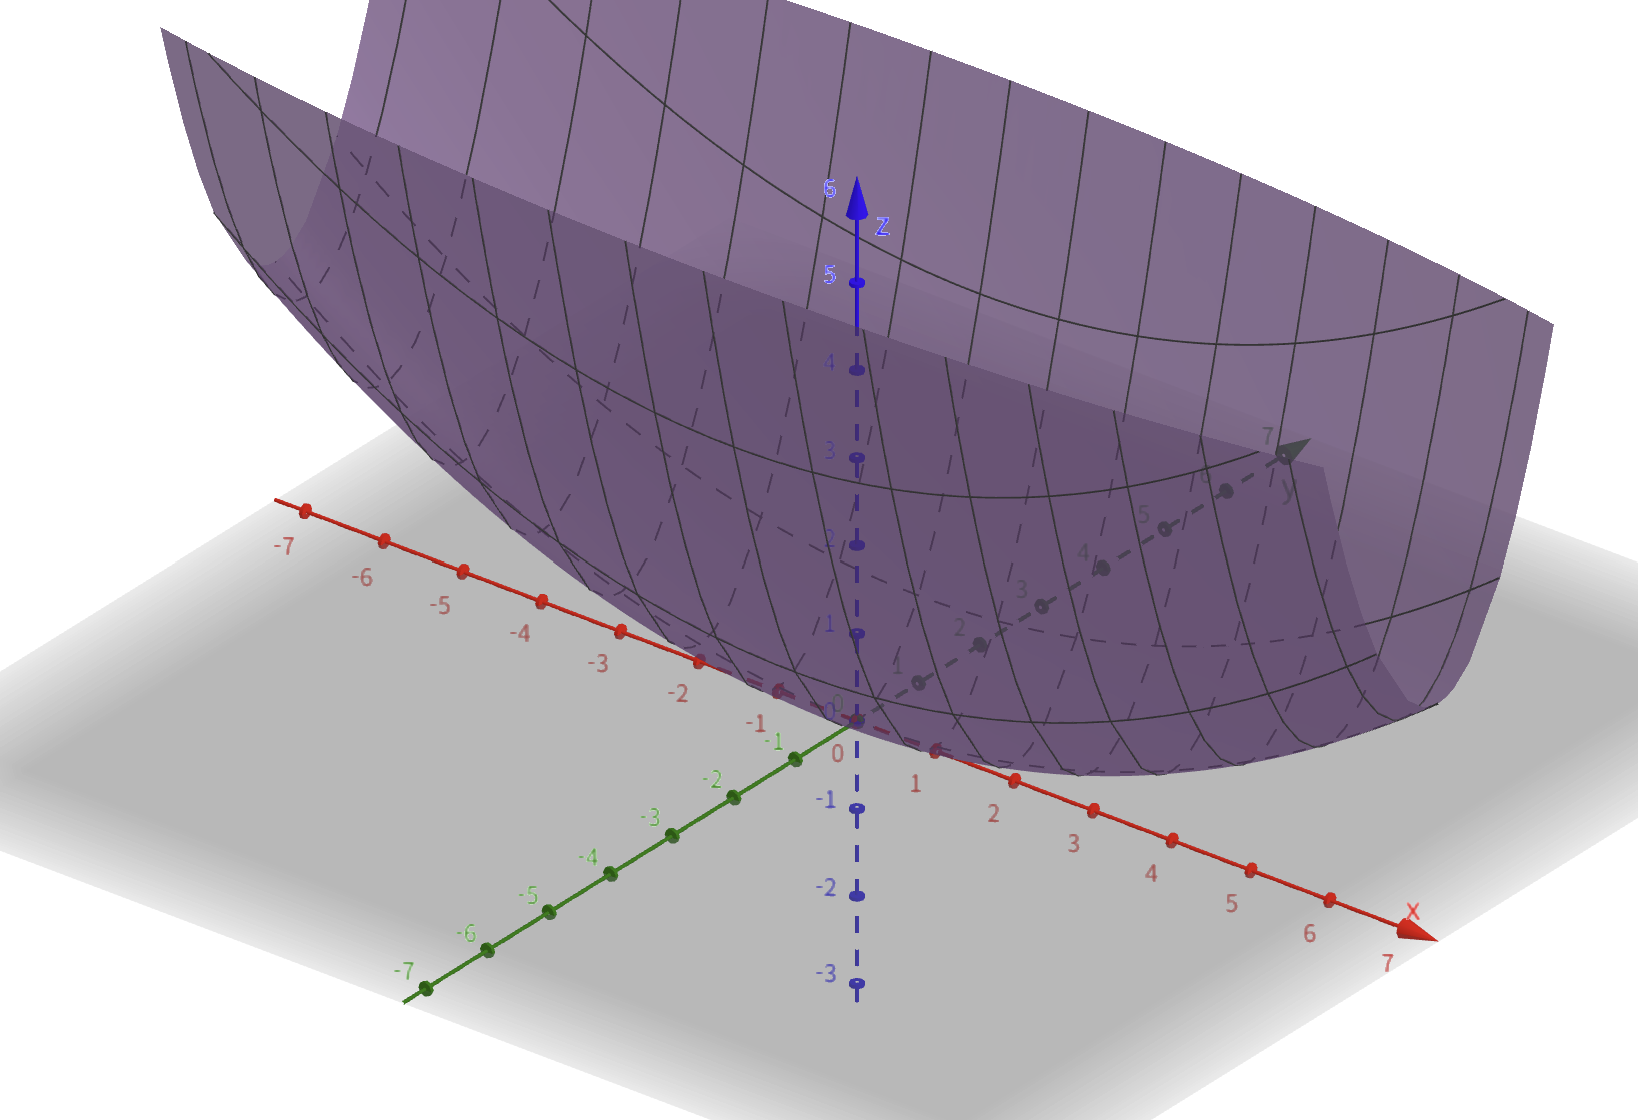

이때 기울기 방향은 y축 축으로는 크고 x축으로는 작음  
따라서 기울기들이 0,0 방향을 가리키지 않음  
결과적으로는 최적화 경로까지 지그재그로 이동하며 굉장히 비효율적으로 움직임  
이를 보완할 방법으로 모멘텀, AdaGrad, Adam 방법

### 모멘텀

모멘텀(Momentum)은 운동량을 뜻하는 단어  
수식으로는 다음과 같으며 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙을 나타냄    
$$ v \leftarrow \alpha v - \eta\frac{\partial L}{\partial W}$$  
$$ W \leftarrow W + v $$
$\eta$ : 학습률  
$\frac{\partial L}{\partial W}$ : W에 대한 손실함수의 기울기  
**$v$ : 물리학에서 말하는 속도에 해당**  
  
$\alpha v$ 항은 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할을 함(물리에서의 지면 마찰이나 공기저항에 해당)

In [2]:
class Momentum:
    def __init__(self, lr =0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key in params.items():
                self.v[key] = np.zeros_like(val)

        for key,val in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

이 방식으로 전의 예시를 풀어보면 지그재그가 덜함  
이는 x축의 힘은 아주 작지만 방향은 변하지 않아서 한방향으로만 일정하게 가속

### AdaGrad  
학습률이 너무 작으면 학습시간이 너무 길어지고 반대로 너무 크면 발산하기에  
**학습률 감소**기법을 사용  
처음에는 크게 학습하다가 점차 줄여나가는 방식으로 실제 신경망학습에 자주 쓰임  
가장 간단한 방법으로 처음에는 매개변수 전체의 학습률 값을 일괄적으로 낮추는 방법이 사용되다가  
이가 발전하여 개별 매개변수에 적응적으로 학습률을 조정하는 AdaGrid 탄생  
$$\begin{aligned}
h & \leftarrow h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} \\
W & \leftarrow W - \eta \frac{1}{\sqrt{h}} \odot \frac{\partial L}{\partial W}
\end{aligned}$$
**$h$ : 기울기의  값을 계속 제곱하여 더함으로써 매개변수를 실제로 갱신할 때 $\frac{1}{\sqrt{h}}$곱해 학습률을 조정(즉, 많이 움직인 원소는 학습률이 낮아짐)**  

구현에서는 $ W \leftarrow W - \eta \frac{1}{\sqrt{h} + \epsilon} \odot \frac{\partial L}{\partial W}$ 식 사용  
$\epsilon$은 0이 들어왔을 때 생기는 오류 방지

In [3]:
class AdaGrid:
    def __init__(self,lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h - {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

            for key in params.keys():
                self.h[key] += grads[key] * grads[key]
                params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key])+1e-7)

앞선 예시의 $f(x,y) = \frac{1}{20} x^2 + y^2$ 에 대하여 지그제그로 움직이지 않고 최솟값을 향해 효율적으로 움직임

### Adam  
모멘텀은 공이 그릇바닥을 구르는 듯한 움직임을 보이고 AdaGrid는 매개변수의 원소마다 적응적으로 갱신 정도 조정  
Adam은 이 둘의 결합 시킨 방법

**네 방법의 비교**  
모든 방면에서 뛰어난 방법은 없음

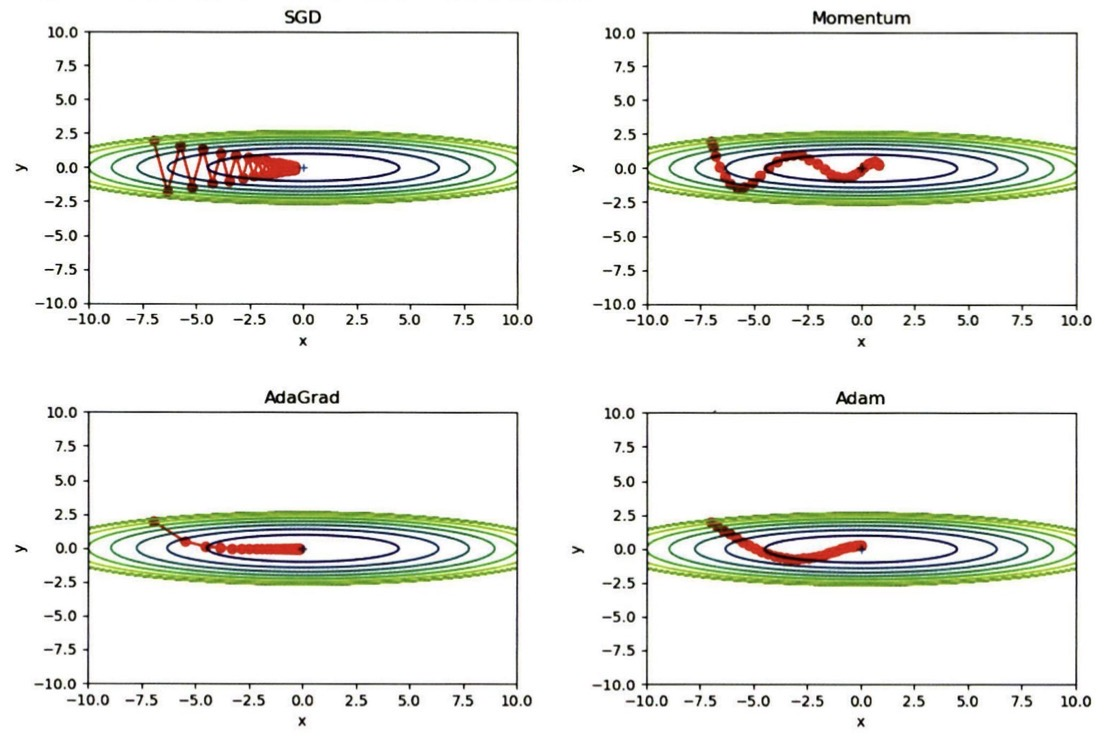

Mnist에 대한 loss 비교

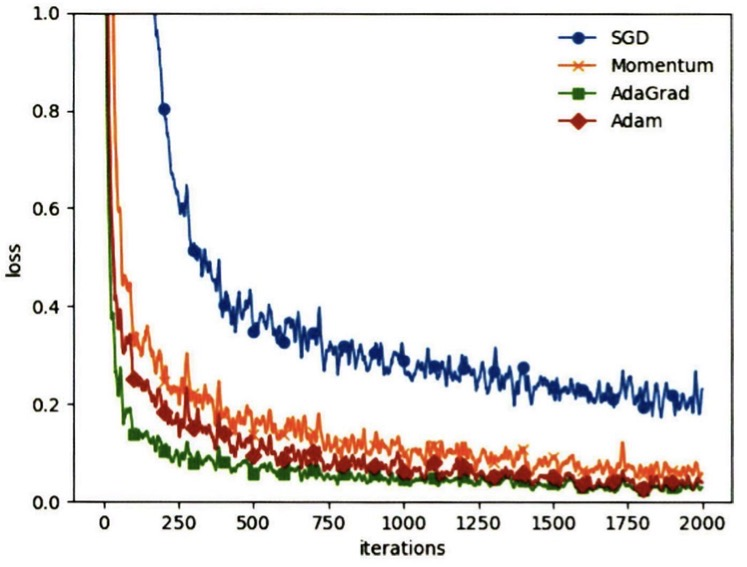

## 6.2 가중치 초깃값

**가중치 감소 기법**  
과대 적합을 억제 해 범용성을 높이는 테크닉  
가중치 매개변수 값이 작아지도록 하는 방법으로 가중치 값이 작아지면 과대적합이 일어나지 않음  

지금까지는 0.01*np.randomn(10,100)처럼 정균분포에서 생성된 값을 작게 만들어 사용  
만약 그냥 0을 사용했었더라면 가중치가 균일한 값이기에 오차역전파에서 모든가중치의 값이 똑같이 갱신 되어 갱신을 거쳐도 같은 값 유지  

**은닉층의 활성화값분포**  
가중치의 초깃값에 따라 은닉층 활성화 값이 어떻게 달라지는지 확인  

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1+np.exp(-x))

x = np.random.randn(1000,100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x,w)
    z = sigmoid(a)
    activations[i] = z

5층 신경망의 가중치값만을 보기위한 모델로  
뉴런 100개짜리 층 5개, 입력 데이터로서 1000개의 데이터를 정규분포로 무작위로 생성하여 5층 신경망에 흘림
처음에는 데이터를 만들어서 쓰고 (1000행 100열) 이후 층에서는 기존의 값을 받아서 사용  
노드가 많은 상황에서 표준편차 1 사용 하였기에 각 노드들이 직전 계층에서 값들을 받으면 그 값들이 모여 활성화 값이 엄청나게 커짐  
이러면 문제가 시그모이드 함수는 아주 큰값에 대해 상수 1로 수렴하는 함수이므로 기울기가 점차 사라지게 됨. 이를 **기울기 소실**이라 부름

활성화 값이 커지는 것 시각화

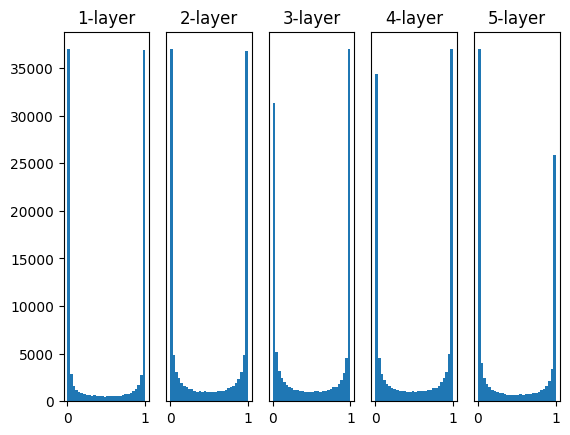

In [5]:
for i,a in activations.items():
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1)+"-layer")
    if i != 0:plt.yticks([],[])
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

실제로 시그모이드를 통과한 활성화 값이 0과 1에 밀집 되어있는 것을 확인할 수 있음  

가중치의 표준표차를 0.01로 바꾸어 같은 실험 진행 시  

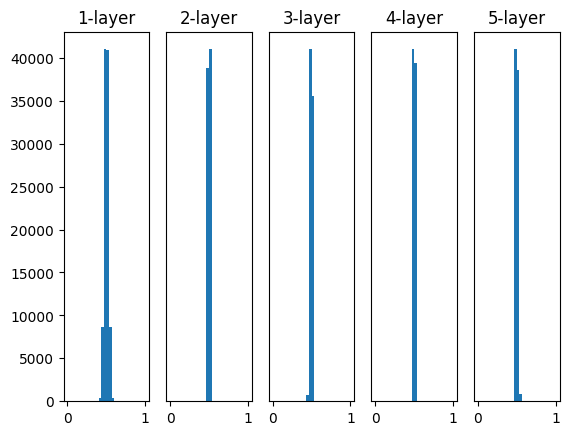

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1+np.exp(-x))

x = np.random.randn(1000,100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x,w)
    z = sigmoid(a)
    activations[i] = z

for i,a in activations.items():
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1)+"-layer")
    if i != 0:plt.yticks([],[])
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

앞의 예처럼 0과 1로 치우치지 않았으니 기울기 소실 문제는 발생하지 않았다고 얘기 할 수 있음  
단, 활성화 값들이 전부 0.5로치우쳐 있음  
이는 다수의 뉴런이 거의 같은 값을 가리키고 있어 뉴런을 많이 둔 이유가 없다는 뜻  
이런 상황을 활성화 값들이 치우치며 **표현력을 제한**하는 문제가 발생했다고 부름  

위 문제들을 해결하기 위한 방법으로 **Xaiver(사비에르) 초깃값** 사용  
현재 Xaiver 초깃값은 일반적인 딥러닝 프레임 워크들이 표준적으로 이용하고 있음  
**활성화 값들을 광범위하게 분포 시키기 위해서 앞계층의 노드가 n개라면 표준편차가 $\frac{1}{\sqrt{n}}$인 분포 사용하면 된다는 결론**

Xaiver 초깃값을 사용하면 앞 층에 노드가 많을수록 대상 노드의 초깃값으로 설정하는 가중치가 좁게 퍼짐  
  
이를 반영한 실험

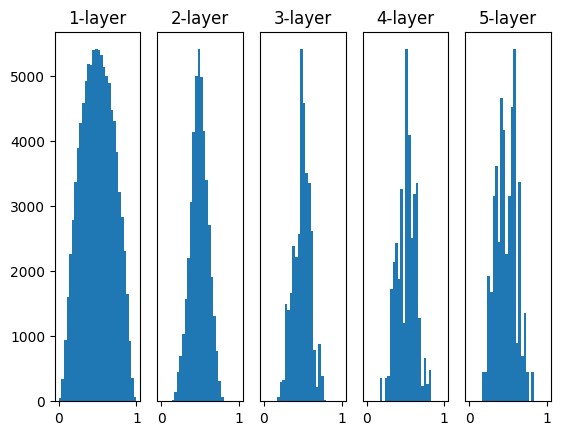

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1+np.exp(-x))

x = np.random.randn(1000,100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x,w)
    z = sigmoid(a)
    activations[i] = z

for i,a in activations.items():
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1)+"-layer")
    if i != 0:plt.yticks([],[])
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

형태가 다소 일그러지지만 앞에서 본 방식보다는 확실히 넓게 분포됨

**ReLU를 사용할 때의 가중치 초깃값**  
sigmoid와 tanh는 좌우 대칭이라 중간이 선형임  
따라서 Xavier 초깃값이 적당함  
반면 ReLU에는 ReLU에 특화된 초깃값인 **He 초깃값**필요  
**He초깃값은 앞계층의 노드가 n개일 때 표준편차가 $\sqrt{\frac{2}{n}}$인 정규 분포 사용**  

ReLU에 Xavier를 사용하면 초기값이 층이 깊어짐에 따라 치우침이 커지고 결국에 깊은 층에서 기울기 소실문제를 일으킴

## 6.3 배치 정규화

6.2에서 가중치의 초깃값을 적절히 설정하면 활성화 분포가 적절히 퍼지면서 학습이 원활하게 수행됨을 배웠음  
그냥 처음부터 활성화 분포가 잘 퍼지도록 강제하는 방법이 **배치 정규화**  

장점  
* 학습을 빨리 진행 시킬 수 있음(학습속도 개선)
* 초깃값에 크게 의존하지 않음(초깃값 선택 불필요)
* 과대적합 억제

배치 정규화 계층을 신경망에 삽입  
각 Layer에 Affine 계층과 RELU 계층 사이에 배치 정규화 계층을 삽입  
기존 : Affine -> ReLU -> Affine -> ReLU -> Affine -> Softmax  
배치 정규화 : Affine -> **BatchNorm** -> ReLU -> Affine -> **BatchNorm** -> ReLU -> Affine -> Softmax  

구체적 방법  
데이터 분포가 평균이 0, 분산이 1이 되도록 정규화  
수식으로는 다음과 같음  
미니배치 평균 (Mean)
$$\mu_{\mathcal{B}} \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_i$$
미니배치 분산 (Variance)
$$\sigma_{\mathcal{B}}^2 \leftarrow \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_{\mathcal{B}})^2$$
정규화 (Normalize)
$$\hat{x}_i \leftarrow \frac{x_i - \mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^2 + \epsilon}}$$

그냥 기본적인 통계학의 그 정규화  
배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대와 이동 변환을 수행  
$$y_i = \gamma \hat{x}_i + \beta$$
$\gamma$가 확대를 $\beta$가 이동을 담당함  
각각 1,0부터 시작하여 학습하면서 적절한 값으로 조정됨

## 6.4 바른학습을 위해

**과대적합**  
신경망이 데이터에 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태를 말함  
머신러닝은 범용 성능을 지향하기 때문에 처음보는 데이터에도 잘 적용 되어야 함  

과대적합이 일어나는 경우는 보통  
* 매개변수가 많고 표현력이 높은 모델일 때
* 훈련데이터가 적은 모델일 때

다음은 일부로 과대적합을 일으킨 경우

In [8]:
import sys, os
sys.path.append(os.pardir)
import numpy as np

from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label=True)
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size=784,hidden_size_list=[100,100,100,100,100,100],output_size=10)
optimizer = SGD(lr=0.01)
max_epochs = 201

train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

epoch_cnt = 0
for i in range(10000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

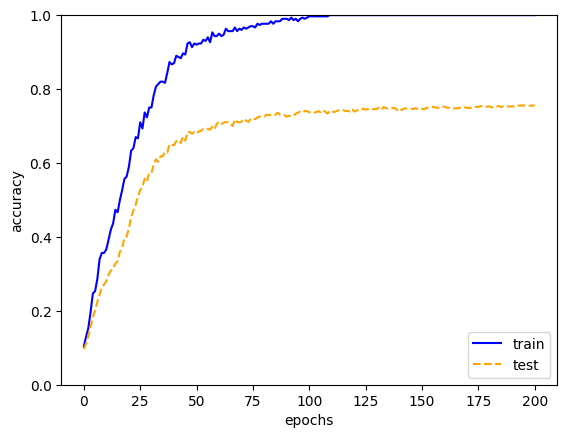

In [9]:
import matplotlib.pyplot as plt

epochs = np.arange(len(train_acc_list))

plt.plot(epochs, train_acc_list, label='train', color='blue')

plt.plot(epochs, test_acc_list, label='test', linestyle='--', color='orange')

plt.xlabel("epochs")
plt.ylabel("accuracy")    
plt.ylim(0, 1.0)
plt.legend(loc='lower right')

plt.show()

100에포크를 지나는 시점부터 거의 정확도가 100에 수렴해버리지만 시험용 데이터에서는 80도 안나옴  
이는 훈련데이터에만 적응 되어버린 오버피팅

**가중치 감소**  
학습과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 과대적합을 억제하는 방법  
원래 과대적합은 가중치 매개변수의 값이 커서 발생하는 경우가 많음  

L2노름을 손실함수에 더해 가중치가 커지는 현상 억제 가능  
수식 : 가중치$W$에 대해 L2노름에 따른 가중치 감소는 $$\frac{1}{2} \lambda W^2$$
$$ L2노름 = \sqrt{w_1^2 + w_2^2 + ... w_ n^2} $$
L2노름의 제곱은 가중치 제곱의 합이므로 $W^2$는 스칼라 숫자 하나를 제곱했다는 뜻이 아니라,   
바로 이 '가중치 원소들의 제곱의 합(Squared L2 Norm)'을 짧게 줄여 쓴 기호  
$\lambda$를 크게 설정할수록 큰 가중치에 대한 페널티가 커짐  
$\frac{1}{2}$은 미분결과인 $\lambda W^2$을 조정하는 역할의 상수  


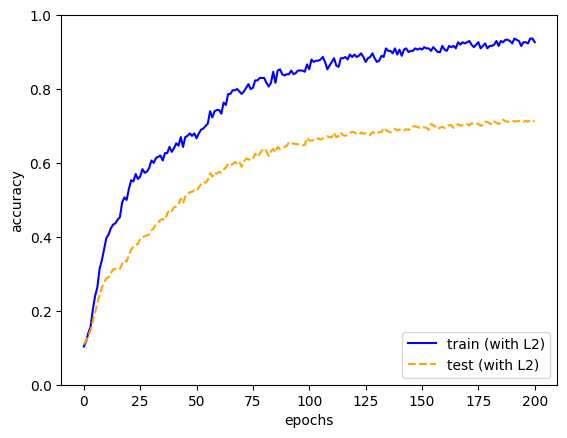

In [10]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt

from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size=784, 
                        hidden_size_list=[100, 100, 100, 100, 100, 100], 
                        output_size=10,
                        weight_decay_lambda=0.1)

optimizer = SGD(lr=0.01)
max_epochs = 201

train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

epoch_cnt = 0
for i in range(100000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epochs = np.arange(len(train_acc_list))
plt.plot(epochs, train_acc_list, label='train (with L2)', color='blue')
plt.plot(epochs, test_acc_list, label='test (with L2)', linestyle='--', color='orange')

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

과대적합이 억제됨  
훈련데이터에 대한 정확도와 시험 데이터에 대한 정확도에는 여전히 차이가 있지만  
가중치 감소를 이용하지 않은 그림과 비교시 차이가 줄었음

**드롭아웃**  
뉴런을 임의로 삭제하면서 학습하는 방법  
훈련때 데이터를 흘릴 때마다 은닉층의 뉴런을 무작위로 골라 삭제  
삭제된 뉴런은 신호를 전달하지 않게 됨  
시험때 모든 뉴런데 신호전달하되 각 뉴런의 출력에 훈련때 삭제 안 한 비율을 곱하여 출력  

In [11]:
class Dropout:
    def __init__(self,dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self,x,train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x*(1.0-self.dropout_ratio)

    def backward(self,dout):
        return dout * self.mask

0~1사이의 숫자를 뽑아 확률적으로 0을 만들고 그걸 곱해버림  
특정 뉴런에 의존하게 되는 과대적합을 원천 차단 가능  
훈련데이터와 시험데이터에 대한 정확도차이가 줄어듦  

참고  
앙상블 학습 : 개별적으로 학습시킨 여러 모델의 출력을 평균을 내어 추론하는 방식. 이는 학습때 뉴런을 무작위로 삭제하는 드롭아웃과 비슷함.

## 6.5 적절한 하이퍼파라미터 찾기

하이퍼파라미터 : 각층의 뉴런 수, 배치 크기, 매개변수 갱신 시 학습률, 가중치 감소 등  
이를 최대한 효율적으로 탐색하는 방법

**검증데이터**  
지금까지는 데이터셋을 훈련데이터와 시험데이터라는 두가지로 분리해 이용  
**하이퍼파라미터의 성능을 평가할때는 시험데이터를 사용하면 시험데이터에 하이퍼파라미터가 과대적합 되어버림**  
따라서 검증데이터라는 하이퍼파라미터 조정용 데이터 필요  
* 훈련 데이터 : 매개변수학습
* 검증 데이터 : 하이퍼파라미터의 성능 평가
* 시험 데이터 : 신경망의 범용 성능 평가


In [15]:
from common.util import shuffle_dataset
(x_train, t_train), (x_test, t_test) = load_mnist()

x_train, t_train = shuffle_dataset(x_train, t_train)
validation_rate = 0.2
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

위 코드는 데이터가 치우치지 않도록 훈련데이터를 분리하기전에 입력 데이터와 정답레이블을 뒤섞음

**하이퍼파라미터 최적화**  
핵심은 하이퍼파라미터의 최적값이 존재하는 범위를 조금씩 줄여나가는 것  
대략적인 범위를 정한 뒤 무작위로 범위 내의 값을 골라낸 후 정확도 평가  
범위를 조금씩 줄여 나가면서 최적값으로 수렴  
(GridSearch보다 무작위 탐색이 더 좋은 결과를 가져온다는 연구결과가 있다고 함)  

Steps  
0. 하이퍼파라미터 값의 범위 설정  
1 설정된 범위세어 하이퍼파라미터의 값 무작위 추출  
2. 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 에포크 작게해서 검증 데이터로 정확도를 평가  
3. 1,2단계를 일정횟수 반복하여 정확도의 결과를 보고 하이퍼파라미터의 범위를 설정함  

## 6.6 정리
* 매개변수 갱신방법에는 경사하강법 외에도 모멘텀, AdaGrid, Adam등이 있다
* 가중치 초깃값을 정하는 방법은 올바른 학습을 하는데 매우중요하다
* 가중치의 초깃값으로 Xavier초깃값과 He초깃값이 효과적이다
* 배치 정규화를 이용하면 학습을 빠르게 진행할 수 있으며, 초깃값에 영향을 덜 받게 된다
* 과대적합을 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있다
* 하이처파라미터 값 탐색은 최적값이 존재할만한 범위를 점차 좁히는 것이 효과적이다